# Baseline trading strategy

Implement a very simple intraday trading strategy and compare to buy-and-hold.

**Stratrgy**: Buy stock at the start of each day. Sell if price reaches X% of open price, otherwise sell at end of the day.

It is forseen that this basic strategy can be improved by the following:

1) Develop a signal to decide whether its worth investing on a given day, rather than blindly investing every day.

2) Generalize trading signal beyond 1 stock. Invest in only those with the greatest chance of reaching X% threshold.

3) Use some kind of portfolio optimisation in order to determine how funds will be distributed amongst the stocks that satisfy the trading signal.

4) Set a lower threshold i.e if stock depreciates by Y%, then sell. This would require intraday data, which is not typically available for free. Lets see how point (1), (2) and (3) go before resorting to that.

5) Set a rolling upper threshold, so that profits can go beyond X%, but locking in profits as we go. Again, this requires intraday data to validate.


**Limitation**: Evaluating the effectiveness of this trading strategy relies on the assumption that it's easily possible to buy stocks at the quoted "open" price each day...

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from market_analysis.dataset import get_stock_data
from market_analysis.features import get_Nday_return
from loguru import logger
import matplotlib.pyplot as plt
plt.style.use('ggplot')


logger.disable("market_analysis")

INITIAL_FUND = 1e6 # Lets start with an initial fund worth £1 million

In [13]:
df = get_stock_data("AAPL", end_date=(2024, 12, 6), days=365.25*6)
get_Nday_return(df, days=1, log=False)
df['OPEN2HIGH_RTN_D1'] = df.eval('high/open - 1')

[*********************100%***********************]  1 of 1 completed


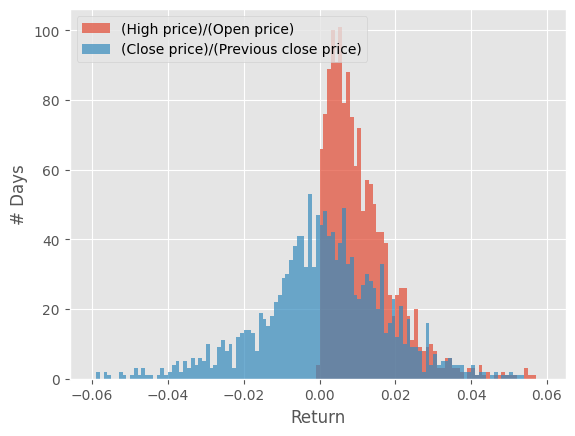

In [14]:
# Compute maximum return on a give day, if we buy stock at the open price
df['OPEN2HIGH_RTN_D1'].hist(
    bins=np.arange(-0.06, 0.06, 0.001), 
    alpha=0.7, 
    label='(High price)/(Open price)'
)

df['RTN_D1'].hist(
    bins=np.arange(-0.06, 0.06, 0.001),
    alpha=0.7, 
    label='(Close price)/(Previous close price)'
)

plt.xlabel('Return')
plt.ylabel('# Days')
plt.legend(loc='upper left')

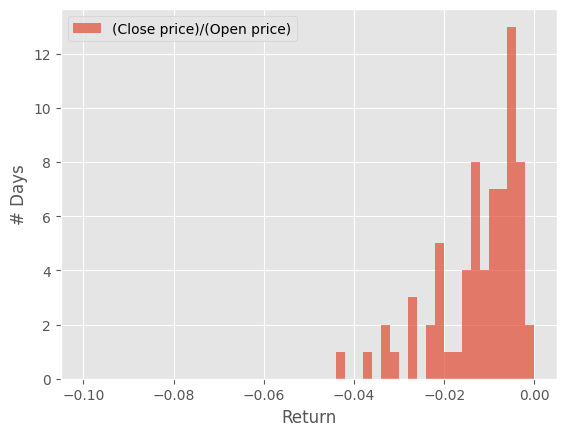

In [15]:
# For the days that (High price)/(Open price) < 0.001, what is the distribution of (Close Price)/(Open price)
# These are the days we want to avoid trading on!
df.query('OPEN2HIGH_RTN_D1 < 0.001').eval('close/open - 1').hist(
    bins=np.arange(-0.1, 0.002, 0.002), 
    alpha=0.7, 
    label='(Close price)/(Open price)'
)

plt.xlabel('Return')
plt.ylabel('# Days')
plt.legend(loc='upper left')

# Buy-and-hold strategy
On day 1, buy as many stocks as possible at the close price

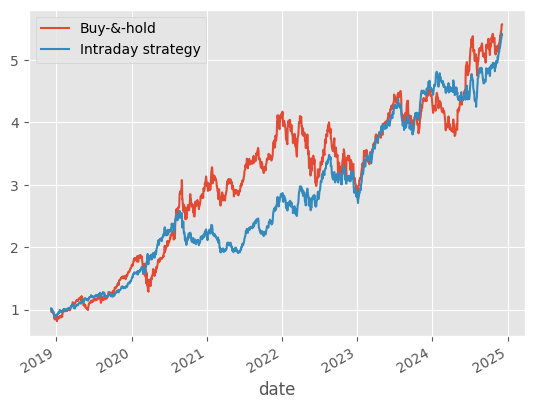

In [30]:
# Buy and hold strategy
(df['close']/df.iloc[0]['close']).plot(label='Buy-&-hold')

returns  = np.array([])

threshold = 0.02
for row in df.iterrows():

    if row[1]['OPEN2HIGH_RTN_D1'] > threshold:
        returns = np.append(returns, 1 + threshold)
    else:
        returns = np.append(returns, (row[1]['close']/row[1]['open'])) 
        
df['BASELINE_RTN'] = np.cumprod(returns)

df['BASELINE_RTN'].plot(label='Intraday strategy')
plt.legend()

In [11]:
np.sum(df['high'] > df['open'])

np.int64(71)